## Some test data

Download some data set (~120Mb for gamma and ~40Mb for protons)

In [1]:
! mkdir -p gamma
! scp cp03:/fefs/aswg/workspace/ievgen.vovk/lst/allsky-mc-irf/mc/dl2-merged/dec_3476/GammaDiffuse/node_corsika_theta_19.807_az_66.706_/dl2_simtel_corsika_theta_19.807_az_66.706_merged.h5 gamma/

! mkdir -p protons
! scp cp03:/fefs/aswg/workspace/ievgen.vovk/lst/allsky-mc-irf/mc/dl2-merged/dec_3476/Protons/node_corsika_theta_19.807_az_66.706_/dl2_simtel_corsika_theta_19.807_az_66.706_merged.h5 protons/

dl2_simtel_corsika_theta_19.807_az_66.706_mer 100%  117MB   4.6MB/s   00:25    
dl2_simtel_corsika_theta_19.807_az_66.706_mer 100%   43MB   4.5MB/s   00:09    


## Read data and compute reconstruction offset

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot

In [3]:
file_name = "gamma/dl2_simtel_corsika_theta_19.807_az_66.706_merged.h5"
data = pd.read_hdf(
    file_name,
    key='dl2/event/telescope/parameters/LST_LSTCam'
)

In [4]:
data.head()

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,...,reco_disp_dx,reco_disp_dy,reco_src_x,reco_src_y,signed_time_gradient,signed_skewness,reco_alt,reco_az,reco_type,gammaness
0,6108,305,139.784452,2.145459,-0.286605,-0.978892,1.019986,-1.855621,0.091540,0.004605,...,0.265447,0.058359,-0.021158,-0.920533,-0.000476,0.273532,1.223013,1.071958,101,0.467894
1,6108,2102,283.647049,2.452778,-1.069087,0.101317,1.073878,3.047105,0.161900,0.005048,...,1.140419,-0.108149,0.071332,-0.006833,24.335710,-0.399328,1.227533,1.163547,0,0.936994
2,6108,2105,7344.950595,3.865989,-0.656207,-0.602423,0.890798,-2.398901,0.289746,0.002111,...,0.563516,0.642272,-0.092691,0.039849,12.816988,-0.445904,1.221933,1.168217,0,0.702838
3,6108,2107,15707.768515,4.196114,-0.476823,-0.678694,0.829449,-2.183238,0.375703,0.001613,...,0.454251,0.768208,-0.022573,0.089513,10.134242,-0.053357,1.224316,1.173234,0,0.903293
4,6108,2904,55.009393,1.740437,-0.959845,-0.136288,0.969472,-3.000546,0.098420,0.005319,...,0.411071,0.113537,-0.548774,-0.022751,-0.786138,0.178793,1.206372,1.162061,0,0.536699


In [5]:
data.columns

Index(['obs_id', 'event_id', 'intensity', 'log_intensity', 'x', 'y', 'r',
       'phi', 'length', 'length_uncertainty', 'width', 'width_uncertainty',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'alt_tel', 'az_tel', 'sin_az_tel', 'calibration_id',
       'mc_energy', 'log_mc_energy', 'mc_alt', 'mc_az', 'mc_core_x',
       'mc_core_y', 'mc_h_first_int', 'mc_type', 'mc_az_tel', 'mc_alt_tel',
       'mc_x_max', 'mc_core_distance', 'wl', 'tel_id', 'tel_pos_x',
       'tel_pos_y', 'tel_pos_z', 'trigger_type', 'trigger_time', 'event_type',
       'disp_dx', 'disp_dy', 'disp_norm', 'disp_angle', 'disp_sign', 'src_x',
       'src_y', 'log_reco_energy', 'reco_energy', 'reco_disp_norm',
       'reco_disp_sign', 'reco_disp_sign_proba', 'reco_disp_dx

In [18]:
# https://github.com/cta-observatory/cta-lstchain/blob/e4a5b7a36dfd643acf47b9006f51fe882b6dbc5c/docs/examples/irf_dl3_tool_config.json#L4
standard_cuts = 'gammaness > 0.7 & intensity > 50 & r < 1 & wl > 0.01 & wl < 1 & leakage_intensity_width_2 < 1'
data = data.query(standard_cuts)

In [19]:
data['reco_offset'] = data.eval('sqrt((reco_src_x - src_x)**2 + (reco_src_y - src_y)**2)')

In [20]:
energy_edges = 10**np.arange(
    np.log10(0.05),
    np.log10(100),
    step=0.2
)

r68 = [
    np.percentile(
        data.query(f'(mc_energy > {emin}) & (mc_energy < {emax})')['reco_offset'],
        68
    )
    for emin, emax in zip(energy_edges[:-1], energy_edges[1:])
]
r68 = np.array(r68)

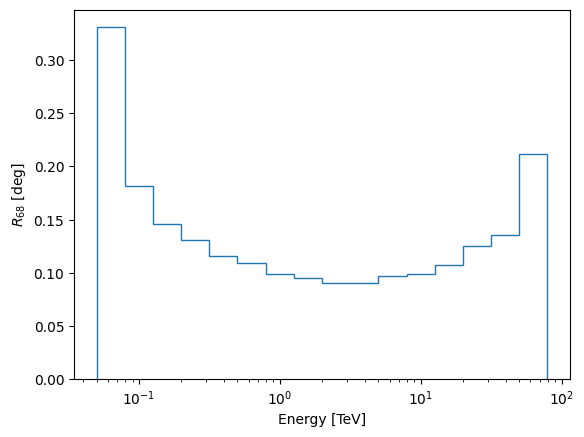

In [23]:
pyplot.semilogx()
pyplot.xlabel('Energy [TeV]')
pyplot.ylabel('$R_{68}$ [deg]')
pyplot.stairs(
    r68,
    energy_edges
)